<a href="https://colab.research.google.com/github/jyao25/COVID-3-plots-trial/blob/main/lab1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Names (Enter your names below)
**Your Name and JHED:** coco yao jyao25

**Partner's Name and JHED (If applicable):**  ...

# Lab 1: Heart Rate Estimation and Signal De-noising
By **Benjamín Béjar Haro** and edited by **Kwame Kutten**

In this lab we will address the problem of heart rate estimation from noisy observations. For a healthy individual, and under ideal conditions, this task might be easy to accomplish. However, different disorders together with different sources of error cause distortions to the signal rendering the estimation task more difficult. We will study how prior information about the signal and the interference can be exploited in order to improve the estimation task under less ideal conditions.

We will start detecting the QRS-complex assuming we have a template of the underlying waveform. Later, we will move to a more realistic scenario where we will be implementing a simplified version of the Pan-Tompkins algorithm [Pan-Tompkins algorithm](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=4122029) and we will test it on real ECG data recordings.

### Objectives
By the end of this session you should be able to understand the main challenges in the estimation of EGC signals. How to work from modeling assupmtions in order to exploit your prior knowledge in the estimation task.

***

### Task 1. Signal generation and template matching
In this task we will implement a simple version of a QRS-complex detector by using template matching, thresholding and non-maximum suppresion on the
observed ECG signal. We will then use those detections to provide an estimate of the heart rate.

* **Task 1A: Signal Generation [15 points total] -** We are going to create a synthetic EGC signal that we will be using to test our detector algorithm. Each pulse should have a sampling rate of $f_s = 256\ Hz$. The goal of this task is to create a basic model for a ECG signal. You can think of the signal as the convolution of a canonical pulse shape $\varphi(t)$ with a stream of Dirac delta functions:

   $$x(t) = \sum_{k=1}^K a_k\, \varphi(t-t_k) = \varphi(t) \ast \sum_{k=1}^K a_k\, \delta(t-t_k),$$

   where $K$ is the number of pulses observed, $a_k$ represent the amplitudes of the different pulses and $t_k$ correspond to the locations of the pulses in time.
  * Generate a stream of $K = 10$ equally spaced pulses over a time span of $10\ s$ using the canonical pulse shape generated by the `ecg_wave()` function defined in the notebook and constant unit amplitudes $a_k=1$ [7 points].
  * Plot the generated signal over time [6 points]
  * Add x-axis and y-axis labels [2 points]


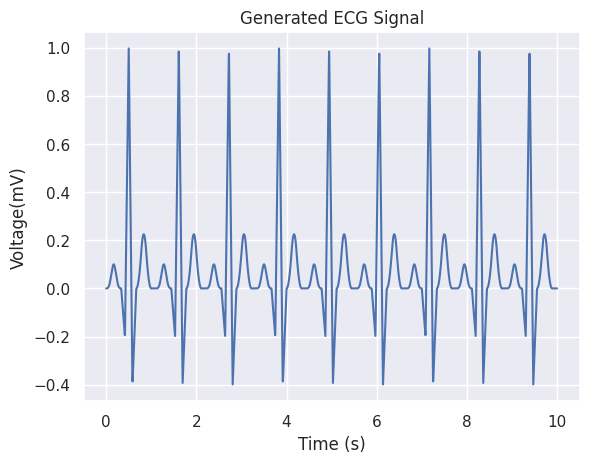

In [1]:
# ============================================================================
# import modules
# ============================================================================
# Note that this part of the code needs to be run prior to any other code cell

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
from scipy.interpolate import BSpline

# inline plots
%matplotlib inline
sns.set()

# ============================================================================
# functions
# ============================================================================
def bspline(x,n):
    """
    Reimplementation since scipy.signal.bspline is no longer supported
    https://docs.scipy.org/doc/scipy-1.12.0/reference/generated/scipy.signal.bspline.html
    """
    knots = np.arange(-(n+1)/2, (n+3)/2)
    res = BSpline.basis_element(knots)(x)
    res[(x<knots[0]) | (x > knots[-1])] = 0
    return res

def ecg_wave(x):
    """
    This function generates a single synthetic ECG template of unit length (support).
    For example, for a sampling frequency of f_s, use x = np.linspace(0,1, f_s, endpoint=False)
    """

    # compute signal (superposition of splines)
    return 0.3 * bspline(3*3*x-7.5,2)\
         + 0.15* bspline(3*4*x-2,3)\
         + bspline(3*2*2*x-6,1) - 0.2 *bspline(3*4*x-5,1) - 0.4 * bspline(3*4*x-7,1)


# ============================================================================
# Write Your code here
# ============================================================================

# Parameters for ECG signal generation
fs = 256  # Sampling frequency in Hz
K = 10  # Number of pulses
T = 10  # Time duration in seconds
t = np.linspace(0, T, T * fs)  # Time vector

ak = np.ones(K)  # Constant unit amplitudes
tk = np.linspace(0, T, K)  # Equally spaced pulse locations

x_t = np.zeros(len(t))

# Sum of equally spaced ECG pulses
for i in range(K):
    x_t += ak[i] * ecg_wave(t - tk[i])

# Plot the generated signal
plt.plot(t, x_t)
plt.xlabel("Time (s)")
plt.ylabel("Voltage(mV)")
plt.title("Generated ECG Signal")
plt.show()

* **Task 1B: Simulate Noise [5 points total]**
  * Generate a noisy version of the synthetic ECG signal generated by adding Gaussian noise with standard deviation $\sigma=0.5$ [2 points].
  * Plot the noisy observations [3 points].

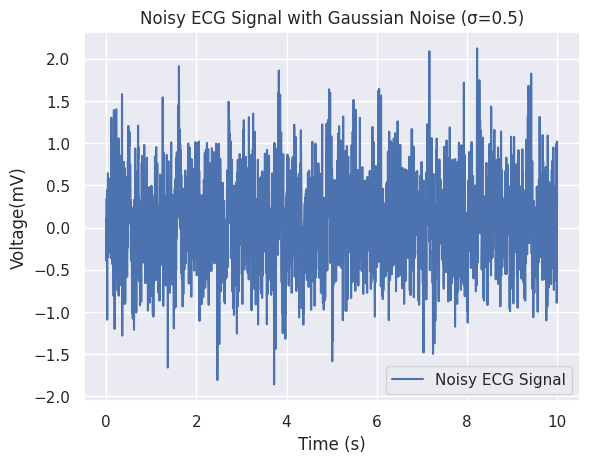

In [2]:
# ============================================================================
# Write Your code here
# ============================================================================

# Generate Gaussian noise with standard deviation sigma = 0.5
sigma = 0.5
noise = np.random.normal(0, sigma, len(t))

# Add noise to the synthetic ECG signal
noisy_x_t = x_t + noise

# Plot the noisy ECG signal
plt.plot(t, noisy_x_t, label='Noisy ECG Signal')
plt.xlabel("Time (s)")
plt.ylabel("Voltage(mV)")
plt.title("Noisy ECG Signal with Gaussian Noise (σ=0.5)")
plt.legend()
plt.show()


* **Task 1C: Find Peaks [10 points total] -** Implement a QRS-complex detector on the noisy signal you just generated. For that purpose we will use template matching, thresholding, and non-maximum suppression.
  * First you should implement template matching by correlating the noisy signal with a template ECG pulse using `np.correlate` [2 points]
  * Next normalize the signal to range $[0,1]$ using `noralize_range` [2 points]
  * Then plot the result [2 points]
  * Select a threshold value in $[0,1]$ that will separate QRS peeks from other peaks [1 point]
  * Next use `signal.find_peaks` with the `height` parameter set to the your chosen threshold to find locations of the QRS peaks [2 points]
  * Print the times of each peak in seconds [1 points]

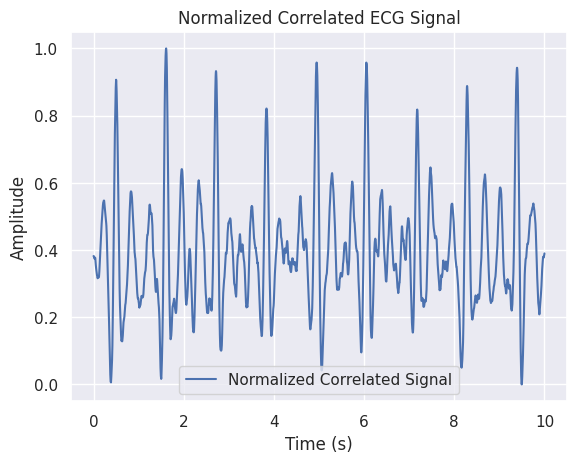

QRS Peak Times (in seconds): [0.50019539 1.61000391 1.95779601 2.33294256 2.71590465 3.8374365
 4.94724502 5.29112935 5.73661587 6.04923798 7.17858538 7.47166862
 8.28448613 8.67917155 9.39429465]


In [ ]:
def normalize_range(x):
    """
    Normalizes the signal such that its minimum value is 0 and its maximum value is 1,
    provided the signal is not identically zero.
    """
    # check that there are non-zero elements
    if np.any(x):

        # subtract minimum
        minx = np.min(x)
        z = x - minx

        # divide by max value
        maxz = np.max(z)
        return z/maxz

    else:
        return x

# ============================================================================
# Write Your code here
# ============================================================================
# Template matching using np.correlate
template = ecg_wave(np.linspace(0, 1, fs, endpoint=False))  # Single ECG pulse
correlated_signal = np.correlate(noisy_x_t, template, mode='same')

# Normalize the correlated signal to range [0,1]
normalized_signal = normalize_range(correlated_signal)

# Adjust the time vector for the correlated signal length
time_correlated = np.linspace(0, T, len(correlated_signal))

# Plot the normalized signal
plt.plot(time_correlated, normalized_signal, label='Normalized Correlated Signal')
plt.xlabel("Time (s)")
plt.ylabel("voltage(mV)")
plt.title("Normalized Correlated ECG Signal")
plt.legend()
plt.show()

# Select a threshold value in [0,1]
threshold = 0.6  # Chosen threshold to separate QRS peaks from others

# Find the peaks using signal.find_peaks with the height parameter
peaks, properties = signal.find_peaks(normalized_signal, height=threshold)

# Print the times of each peak in seconds (adjust for time_correlated)
peak_times = time_correlated[peaks]
print("QRS Peak Times (in seconds):", peak_times)

* **Task 1D: RR Intervals [10 points total]**
  * Verify your results by ploting the original (synthetic) ECG signal overlaid with markers of peak locations. Keep in mind to compensate for any delay you might have introduced by filtering. [5 points]
  * Find the $R$ to $R$ interval sequence $r_n$ and its average value as $$ \bar R = \frac{1}{N}\sum_{n=0}^N r_n, $$ where $N$ is the number intervals between peaks.  Use this to display an estimate of the average heart beat rate in beats per minute (bpm) [5 points].


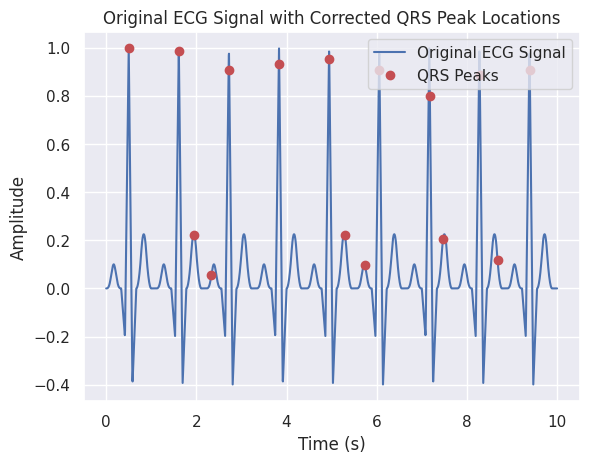

RR Intervals (in seconds): [1.10980852 0.34779211 0.37514654 0.38296209 1.12153185 1.10980852
 0.34388433 0.44548652 0.31262212 1.1293474  0.29308324 0.81281751
 0.39468542 0.71512309]
Average RR Interval: 0.6352928041087479 seconds
Estimated Heart Rate: 94.44 bpm


In [ ]:
# ============================================================================
# Write Your code here: Corrected Task 1D - RR Intervals
# ============================================================================

# Plot the original synthetic ECG signal
plt.plot(t, x_t, label='Original ECG Signal')
plt.xlabel("Time (s)")
plt.ylabel("Voltage(mV)")
plt.title("Original ECG Signal")

# Plot markers on the QRS peaks
plt.plot(peak_times, x_t[np.searchsorted(t, peak_times)], 'ro', label='QRS Peaks')
plt.legend()
plt.show()

# Calculate the RR intervals (difference between consecutive peak times)
rr_intervals = np.diff(peak_times)

# Calculate the average RR interval
average_rr = np.mean(rr_intervals)

# Estimate the average heart rate in beats per minute (bpm)
heart_rate_bpm = 60 / average_rr

print(f"Average RR Interval: {average_rr} seconds")
print(f"Estimated Heart Rate: {heart_rate_bpm:.2f} bpm")


### Task 2. QRS complex detection via Pan-Tompkins algorithm
Now let us consider a more realistic scenario where we have a noisy ECG signal and the waveform of the QRS-complex is unknown. There are different sources of noise that can be present during an ECG acquisition. In addition to high-frequency thermal noise, it is also common to observe the presence of low-frequency interference coming from breathing.
When it comes to pathologies, different non-additive distortions might be present on the ECG signal
that alter the shape of the QRS-complex itself but for the purpose of this task we just assume a healthy  individual where signal distortion comes solely from the acquisition process. The procedure that we will employ in order to estimate the locations of the QRS-complex is based on the Pan-Tompkins algorithm [Pan-Tompkins algorithm](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=4122029).

**Important Note 1:** You may need to **adjust the `myPath` variable below.**

**Important Note 2:** If you are using **Google Colab you must follow these steps**

1. Upload **ecg_mitnst.json** into your Google Drive.  If you placed it in a sub folder called **myFolder** the use `myPath = "myFolder/ecg_mitnst.json"`. Otherwise use `myPath = "ecg_mitnst.json"`
2. Run the folloing cell and follow displayed instructions

Drive already mounted at gdrive/; to attempt to forcibly remount, call drive.mount("gdrive/", force_remount=True).
dict_keys(['fs', 'time', 'tk', 'voltage'])


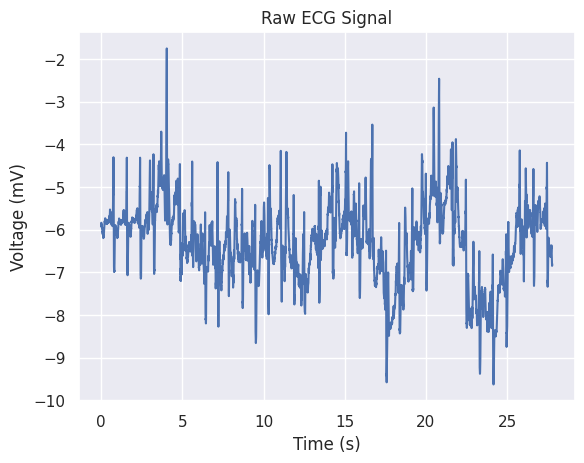

In [ ]:
# ============================================================================
# Edit myPath variable below if necessary
# ============================================================================
import json
import numpy as np
import matplotlib.pyplot as plt

def read_data(path):
    try:
        # Executes if running in Google Colab
        from google.colab import drive
        drive.mount('gdrive/')
        path = 'gdrive/My Drive/' + path
    except:
        # Executes if running locally (e.g. Anaconda)
        pass

    with open(path, 'r') as infile:
        data = json.load(infile)
    return data

# Set the correct path to your file
myPath = "Colab Notebooks/myFolder/ecg_mitnst.json"  # Change myPath to location of data if necessary
data = read_data(myPath)

# Print data keys to inspect the structure
print(data.keys())

# Access the ECG signal (voltage) and other relevant data fields
ecg_signal = np.array(data['voltage'])  # ECG voltage signal
fs = data['fs']  # Sampling frequency
time = np.array(data['time'])  # Time vector from the data

# Plot the raw ECG signal
plt.plot(time, ecg_signal)
plt.xlabel('Time (s)')
plt.ylabel('Voltage (mV)')
plt.title('Raw ECG Signal')
plt.show()


**Task 2A: Effect of noise [10 points]:** The `data` dictionary contains four fields.  `fs` is the sampling frequency, `voltage` is the measured voltage in *mV* at corresponding `time` points and `t_k` contains the indices of the peaks. The signal corresponds to a sample ECG from the [MIT noise stress dataset](https://physionet.org/physiobank/database/nstdb/)
that has been downloaded from [physionet.org](https://physionet.org/physiobank/database/).
Note the presence of a strong low-frequency component.
  * Plot the voltage over time [5 points]
  * Add markers to indicate the given peaks [5 points]

Drive already mounted at gdrive/; to attempt to forcibly remount, call drive.mount("gdrive/", force_remount=True).


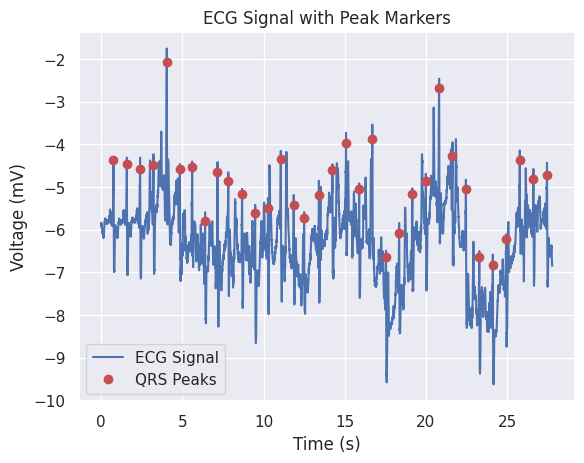

In [ ]:
# ============================================================================
# Write your code here
# ============================================================================
import json
import numpy as np
import matplotlib.pyplot as plt

# Function to read the data
def read_data(path):
    try:
        # For Google Colab
        from google.colab import drive
        drive.mount('gdrive/')
        path = 'gdrive/My Drive/' + path
    except:
        # For local use (Anaconda or other local environments)
        pass

    with open(path, 'r') as infile:
        data = json.load(infile)
    return data

# Set the path to your data file
myPath = "Colab Notebooks/myFolder/ecg_mitnst.json"  # Adjust the path as needed
data = read_data(myPath)

# Accessing the data fields: voltage, fs, time, and t_k (indices of peaks)
ecg_signal = np.array(data['voltage'])  # ECG voltage in mV
fs = data['fs']  # Sampling frequency
time = np.array(data['time'])  # Time in seconds
peaks = np.array(data['tk'])  # Indices of peaks

# Plot the ECG signal (voltage over time)
plt.plot(time, ecg_signal, label='ECG Signal')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (mV)')
plt.title('ECG Signal with Peak Markers')

# Add markers at the peak positions
plt.plot(time[peaks], ecg_signal[peaks], 'ro', label='QRS Peaks')

# Show the legend and display the plot
plt.legend()
plt.show()


#### **Pan-Tompkins Algorithm**
In order to deal with noise we will implement a simplified version of the Pan-Tompkins algorithm. For your convinence we have provided `boxFilter` and `triangleFilter` functions. Proceed as follows:

**Task 2B [10 points total]:** _Bandpass filtering:_ In this first step we want to eliminate as much as possible interference that is present in our acquired signal. In order to do that we can filter the signal and only leave the frequency range
that is of interest for our task (e.g. $5-15$ Hz as suggested in the original Pan-Tompkins paper) the bandpass filtering operation as the concatenation of a lowpass and a highpass filtering steps:

* _Highpass filtering:_ A highpass filter can be thought of as removing the lower frequency component of the signal. That means that we could use a lowpass filter to get a lowpass version of the original signal and then subtract the result from the original series.
   * We will use a lowpass filter of triangular shape and length $L$. Determine the length of the filter based on the required passband (i.e. the filter should attenuate significantly beyond $5$ Hz) or empirically by adjusting the value of $L$. Plot the original signal together with the lowpass filtered version. The latter one should describe the trend in the ECG recording [4 points].
   * Then plot the signal with the lowpass version subtracted to leave high-pass filtered signal [4 points].

* _Lowpass filtering:_ Use an averaging (box) filter to reduce high-frequency noise. Filter the signal with a filter of length $L=10$ taps [3 points].



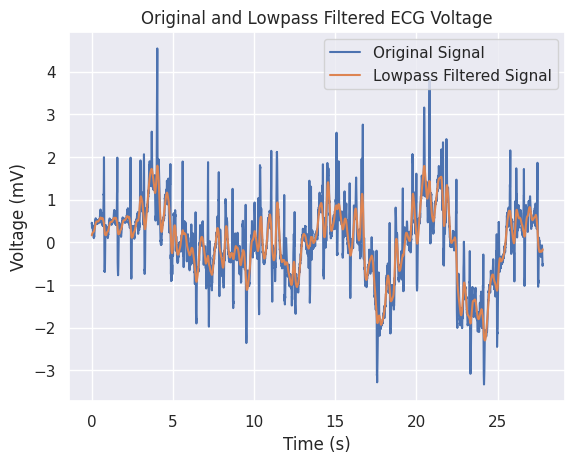

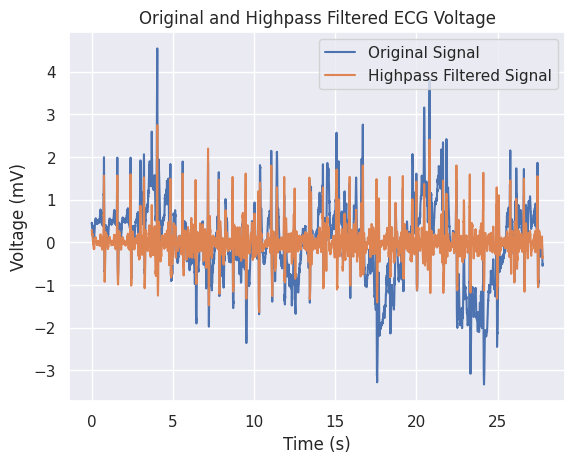

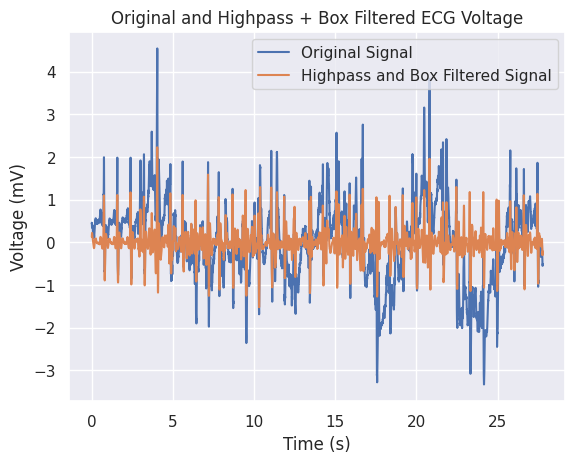

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def boxFilter(L):
    """
    Genearte box filter of length L
    """
    h = np.ones(L)
    return h/np.sum(h)

def triangleFilter(L):
    """
    Generate triangle filter of length L
    """
    h = np.convolve(boxFilter(L//2), boxFilter(L//2))
    h = np.concatenate(([0],h))
    if L % 2: h = np.concatenate((h,[0]))
    return h/np.sum(h)

# ============================================================================
# Write your code here
# ============================================================================

# Step 1: Remove the mean from the ECG signal to center it
ECG = ecg_signal - np.mean(ecg_signal)

# Step 2: Apply a lowpass filter (triangle filter) to the ECG signal
L_lowpass = 100  # Length of the triangular filter
lpfilt = triangleFilter(L_lowpass)
lpECG = np.convolve(ECG, lpfilt, mode='same')

# Step 3: Highpass filter: Subtract the lowpass filtered signal from the original signal
hpECG = ECG - lpECG

# Step 4: Create plots for the filtered signals
plt.figure()
plt.plot(time, ECG, label='Original Signal')
plt.plot(time, lpECG, label='Lowpass Filtered Signal')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (mV)')
plt.title('Original and Lowpass Filtered ECG Voltage')
plt.legend(loc='upper right')
plt.show()

plt.figure()
plt.plot(time, ECG, label='Original Signal')
plt.plot(time, hpECG, label='Highpass Filtered Signal')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (mV)')
plt.title('Original and Highpass Filtered ECG Voltage')
plt.legend(loc='upper right')
plt.show()

# Step 5: Apply a lowpass box filter (L = 10) to further smooth the highpass signal
L_box = 10
boxfilt = boxFilter(L_box)
hpECG_box_filtered = np.convolve(hpECG, boxfilt, mode='same')

# Step 6: Plot the final result
plt.figure()
plt.plot(time, ECG, label='Original Signal')
plt.plot(time, hpECG_box_filtered, label='Highpass and Box Filtered Signal')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (mV)')
plt.title('Original and Highpass + Box Filtered ECG Voltage')
plt.legend(loc='upper right')
plt.show()

**Task 2C [10 points total]:** _Differentiation_
 * Use a 1D numpy array to define the finite difference filter [3 points] $$d_n = \frac{1}{8}\big(\delta_{n-2} + 2\delta_{n-1} -2\delta_{n+1} - \delta_{n+2}\big)$$
 * Then differentiate the resulting signal in order to localize the region of steepest  slope  in  the  QRS-complex [2 points].  
 * Plot the result [5 points]

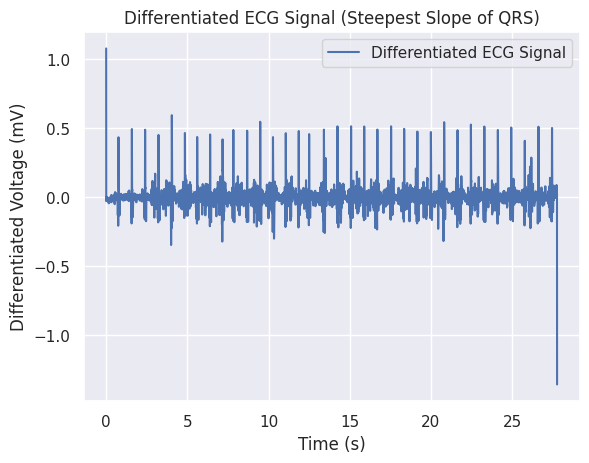

In [ ]:
# ============================================================================
# Write your code here
# ============================================================================
import numpy as np
import matplotlib.pyplot as plt

# Finite difference filter
def differentiation_filter():
    """
    Returns the finite difference filter d_n as a 1D numpy array.
    The filter is: (1/8) * [-1, -2, 0, 2, 1]
    """
    return (1 / 8) * np.array([-1, -2, 0, 2, 1])

# Apply differentiation to the highpass filtered signal from Task 2B
differentiated_signal = np.convolve(highpass_filtered_signal, differentiation_filter(), mode='same')

# Plot the differentiated signal
plt.plot(time, differentiated_signal, label='Differentiated ECG Signal')
plt.xlabel('Time (s)')
plt.ylabel('Differentiated Voltage (mV)')
plt.title('Differentiated ECG Signal (Steepest Slope of QRS)')
plt.legend()
plt.show()


**Task 2D [10 points total]:** _Signal squaring_
 * Square the signal after differentiation [5 points]
 * Plot the result [5 points]

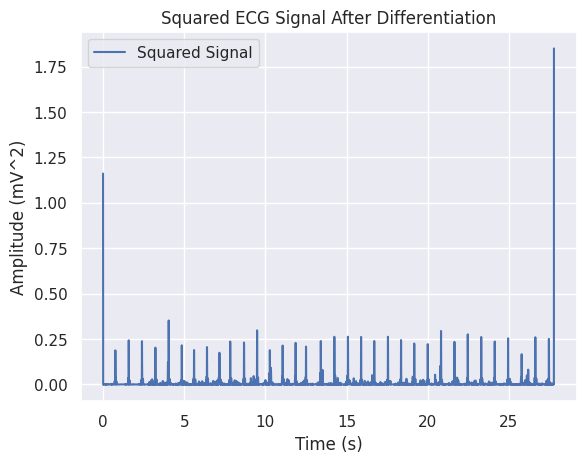

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
# ============================================================================
# Write your code here
# ============================================================================
squared_signal = differentiated_signal ** 2

# Plot the squared signal
plt.figure()
plt.plot(time, squared_signal, label='Squared Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (mV^2)')
plt.title('Squared ECG Signal After Differentiation')
plt.legend()
plt.show()

**Task 2E [10 points total]:** _Integration_
 * Integrate the resulting signal from the squaring operation with a box window of length $L=50$ [5 points]
 * Plot the resulting signal [5 points]

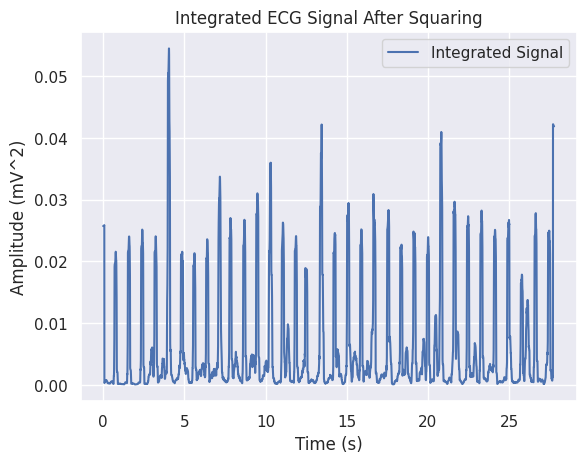

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
# ============================================================================
# Write your code here
# ============================================================================
# Box filter for integration
def boxFilter(L):
    """
    Generate a box filter (averaging filter) of length L.
    """
    return np.ones(L) / L

# Length of the box window for integration
L_integration = 50

# Apply the box filter to the squared signal (integration step)
integrated_signal = np.convolve(squared_signal, boxFilter(L_integration), mode='same')

# Plot the integrated signal
plt.figure()
plt.plot(time, integrated_signal, label='Integrated Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (mV^2)')
plt.title('Integrated ECG Signal After Squaring')
plt.legend()
plt.show()

**Task 2F [10 points total]:** _Peak detection_
 * Use `signal.find_peaks` with an appropriate `height` threshold to estimate locations of QRS peaks [2 points]
 * Replot the previous plot with markers at these peak locations [4 points].
 * In a differnt plot display the heart beat rate over time estimated from the **R** to **R** intervals [4 points]

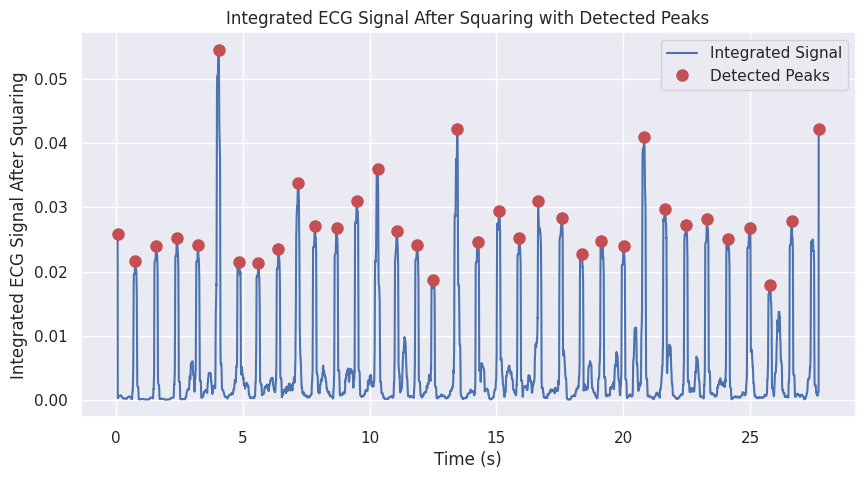

Estimated Average Heart Rate: 74.49 bpm


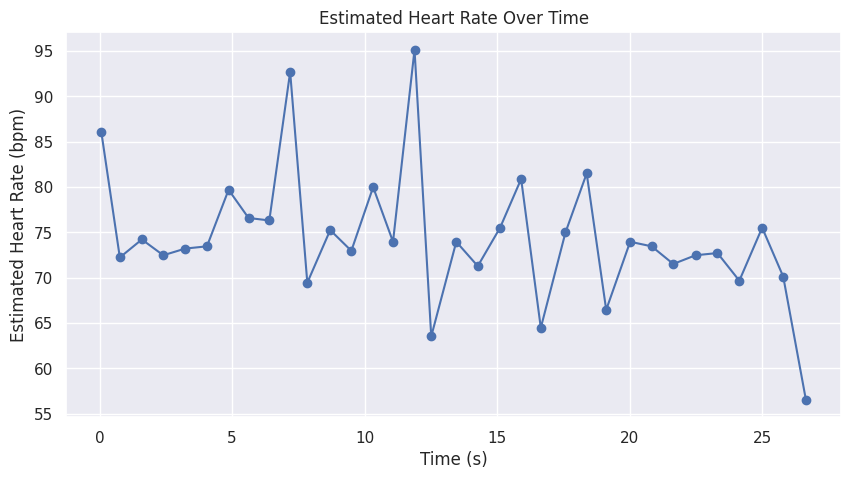

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
# ============================================================================
# Write your code here
# ============================================================================
# Step 1: Detect peaks from the integrated signal
peaks, _ = signal.find_peaks(integrated_signal, distance=0.6 * fs)

# Step 2: Convert 'time' to a NumPy array for indexing
time = np.array(time)

# Step 3: Plot the integrated signal with detected peaks
plt.figure(figsize=(10, 5))
plt.plot(time, integrated_signal, label='Integrated Signal')
plt.plot(time[peaks], integrated_signal[peaks], 'ro', markersize=8, label='Detected Peaks')
plt.xlabel('Time (s)')
plt.ylabel('Integrated ECG Signal After Squaring')
plt.title('Integrated ECG Signal After Squaring with Detected Peaks')
plt.legend()
plt.show()

# Step 4: Calculate RR intervals (time between consecutive peaks)
rr_intervals = np.diff(time[peaks])  # RR intervals in seconds

# Step 5: Calculate heart rate in beats per minute
bpmEstimate = 60 / rr_intervals

# Step 6: Print the estimated average heart rate
avg_heart_rate = np.mean(bpmEstimate)
print('Estimated Average Heart Rate: {:.2f} bpm'.format(avg_heart_rate))

# Step 7: Plot the estimated heart rate over time
plt.figure(figsize=(10, 5))
plt.plot(time[peaks[:-1]], bpmEstimate, marker='o')
plt.xlabel('Time (s)')
plt.ylabel('Estimated Heart Rate (bpm)')
plt.title('Estimated Heart Rate Over Time')
plt.show()
